### Teste Pré-Processamento para remoção de nodes impossíveis de cobrir

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy.ndimage import distance_transform_edt
from skimage.draw import line
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent)) 

from agricultural_csp.instance import AgcspInstance
from agricultural_csp.evaluator import AgcspEvaluator
from agricultural_csp.solution import AgcspSolution 

Node = Tuple[float, float]

# --- 2. CRIAÇÃO DA INSTÂNCIA DE TESTE (CAMPO CIRCULAR COM OBSTÁCULOS) ---
center_r, center_c = 100, 100
outer_radius = 80
obstacle_half_size = 5

r_grid, c_grid = np.mgrid[0:200, 0:200]
dist_from_center = np.sqrt((r_grid - center_r)**2 + (c_grid - center_c)**2)
grid_nodes = np.argwhere(dist_from_center <= outer_radius)

# Definição dos obstáculos (MANTENDO A POSIÇÃO ORIGINAL)
obstacle_positions = [(100, 140), (130, 115), (115, 70), (70, 85), (85, 130)]
obstacle_list = []
for obs_r, obs_c in obstacle_positions:
    obstacle = np.argwhere((np.abs(r_grid - obs_r) <= obstacle_half_size) & 
                           (np.abs(c_grid - obs_c) <= obstacle_half_size))
    obstacle_list.append(obstacle)
obstacle_nodes = np.vstack(obstacle_list)

sprayer_length = 15 # Barra do pulverizador
max_turn_angle = 90 # Ângulo máximo de curva

# INICIALIZAÇÃO E PRÉ-PROCESSAMENTO
circular_inst = AgcspInstance(grid_nodes, obstacle_nodes, sprayer_length, max_turn_angle)
circular_evaluator = AgcspEvaluator(circular_inst)

# Solução inicial simples (4 pontos) para testes
path = [(50, 50), (150, 150), (150, 50), (35, 100)] 
sol = AgcspSolution(path)

print(f"SETUP CONCLUÍDO. Alvos atingíveis: {circular_inst.target_node_count}")
print(f"Custo Inicial da Rota: {circular_evaluator.objfun(sol):.4f}")

SETUP CONCLUÍDO. Alvos atingíveis: 19448
Custo Inicial da Rota: 370.6511


In [2]:
def display_grid_and_path(inst, evaluator, path):
    """
    Display a grid with nodes and path coverage visualization.
    
    Args:
        inst: AgcspInstance object containing grid_nodes and obstacle_nodes
        evaluator: AgcspEvaluator object to calculate coverage
        path: List of (row, col) tuples representing the path
    """
    covered_nodes = evaluator.get_covered_nodes_list(path)
    
    total_nodes = len(inst.field_nodes)
    covered_count = len(covered_nodes)
    coverage_percentage = (covered_count / total_nodes) * 100 if total_nodes > 0 else 0
    
    # Check for obstacle coverage
    covered_obstacles = []
    obstacle_warning = ""
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        covered_set = set(map(tuple, covered_nodes))
        covered_obstacles = [obs for obs in inst.obstacle_nodes if tuple(obs) in covered_set]
        if covered_obstacles:
            obstacle_warning = f" - {len(covered_obstacles)} obstacles covered!"
    
    plt.figure(figsize=(12, 10))
    
    # Plot valid nodes
    plt.scatter(inst.grid_nodes[:, 0], inst.grid_nodes[:, 1], c='#AAAAAA', s=3, 
               label='Uncovered Nodes', alpha=0.7)
    
    if len(covered_nodes) > 0:
        plt.scatter(covered_nodes[:, 0], covered_nodes[:, 1], c='#00AA44', s=4, 
                   label='Covered Nodes', alpha=0.8)
    
    # Plot obstacles
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        plt.scatter(inst.obstacle_nodes[:, 0], inst.obstacle_nodes[:, 1], c='#CC0000', s=4, 
                   marker='s', label='Obstacles', linewidths=0.5)
        
        # Highlight covered obstacles
        if covered_obstacles:
            covered_obstacles_arr = np.array(covered_obstacles)
            plt.scatter(covered_obstacles_arr[:, 0], covered_obstacles_arr[:, 1], 
                       c='#FF6600', s=10, marker='D', 
                       linewidths=2, label='Covered Obstacles')
    
    # Plot path
    path_arr = np.array(path)
    plt.plot(path_arr[:, 0], path_arr[:, 1], color='#9900CC', linewidth=3, 
             label='Sprayer Path', marker='o', markersize=6, markerfacecolor='white', 
             markeredgecolor='#9900CC', markeredgewidth=2)
    
    # Plot start point (green star)
    if len(path) > 0:
        plt.scatter(path_arr[0, 0], path_arr[0, 1], c='#00DD00', s=200, 
                   marker='*', label='Start', edgecolors='black', linewidths=2, zorder=5)
    
    # Plot end point (red square)
    if len(path) > 1:
        plt.scatter(path_arr[-1, 0], path_arr[-1, 1], c='#DD0000', s=100, 
                   marker='s', label='End', edgecolors='black', linewidths=2, zorder=5)
    
    plt.axis('equal')
    plt.legend(loc='upper right', framealpha=0.9)
    
    title = f'Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%){obstacle_warning}'
    plt.title(title, fontsize=12, fontweight='bold')
    
    print(f"Coverage: {covered_count}/{total_nodes} nodes ({coverage_percentage:.1f}%)")
    if hasattr(inst, 'obstacle_nodes') and len(inst.obstacle_nodes) > 0:
        print(f"Obstacles: {len(covered_obstacles)}/{len(inst.obstacle_nodes)} covered")
        if covered_obstacles:
            print("WARNING: Sprayer is covering obstacles!")
    
    plt.show()

Coverage: 5357/19448 nodes (27.5%)
Obstacles: 242/633 covered


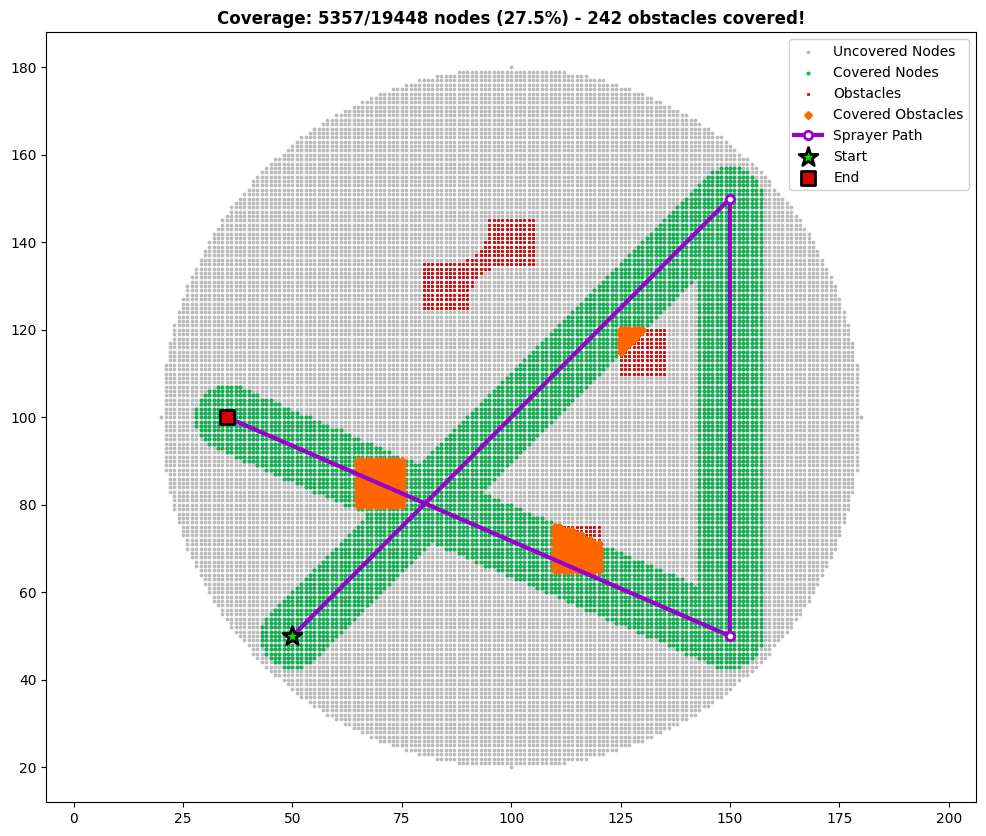

In [3]:
path=[(50, 50), (150, 150), (150, 50), (35, 100)]
display_grid_and_path(circular_inst, circular_evaluator, path)

In [4]:
# --- CÉLULA 3: TESTE DE INSERÇÃO (DEVE SER EXECUTADA APÓS AS ANTERIORES) ---

print("--- Teste de Inserção ---")

# A solução 'sol' e o avaliador 'circular_evaluator' são da Célula 1
initial_cost = circular_evaluator.objfun(sol)

# --- 1. Movimento: Inserir o nó da instância no índice 30, na posição 2 ---
node_to_insert = circular_inst.grid_nodes[30]
position = 2

# 2. DELTA CALCULADO (SEU MÉTODO OTIMIZADO)
calculated_delta = circular_evaluator.evaluate_insertion_delta(sol, node_to_insert, position)

# 3. VERIFICAÇÃO (FORÇA BRUTA)
new_path = np.insert(np.array(sol.path), position, node_to_insert, axis=0)
new_sol = AgcspSolution(new_path)
new_cost = circular_evaluator.objfun(new_sol)
expected_delta = new_cost - initial_cost

# 4. COMPARAÇÃO
print(f"Delta Otimizado: {calculated_delta:.4f}")
print(f"Delta Força Bruta: {expected_delta:.4f}")

if np.isclose(calculated_delta, expected_delta):
    print("\n✅ SUCESSO! O método 'evaluate_insertion_delta' está correto.")
else:
    print("\n❌ FALHA! Os deltas não coincidem.")

--- Teste de Inserção ---
Delta Otimizado: 178.4191
Delta Força Bruta: 178.4191

✅ SUCESSO! O método 'evaluate_insertion_delta' está correto.
